### Lecture 33: Intro to GANs

This notebook will cover the basics in how to set up and train a very simple Generative Adversarial Network.

Source: https://realpython.com/generative-adversarial-networks/


A generative adversarial network is a type of Machine Learning that generates new things sich as images or text. In short, it does this by learning how to mimic and find patterns within a given distribution of data.

Why is a GAN **adversarial**? 

A generative adversarial network is composed of two neural networks, one called the generator and one called the discriminator.

- The _generator_ estimates the probability distribution of the real samples in order to provide generated samples resembling real data.

- The _discriminator_ is trained to estimate the probability that a given sample came from the real data rather than being provided by the generator.

The GAN training process consists of a two-player minimax game in which the discriminator adapts to minimize the discrimination error between the real and generated samples, and the generator adapts to maximize the probability of the discriminator making a mistake. 

In [1]:
import torch
from torch import nn

In [2]:
import math
import matplotlib.pyplot as plt

In [3]:
torch.manual_seed(111)

**PART A:** We will consider a toy example with a dataset composed of two-dimensional samples $(x_1, x_2)$, with $x_1$ in the interval from $0$ to $2\pi$ and $x_2 = \sin(x_1)$.

First, let's create training data. The training data will be comprised of $(x_1, x_2)$ pairs using the equation: $x_2 = sin(x_1)$. 

We will make a training set with 1024 pairs. Then we will initialize the training set to be a tensor with 1024 rows and 2 columns of zeros. We will use the first column of the training set to store random values from the interval $[0, 2\pi]$, and the second column of the training set will be the sine of the first column.

Next we will create a tensor of labels. Note that GANs are a form of unsupervised learning, so the labels can be anything.

The PyTorch dataloader will expect a training set that is a list of tuples that contain the data itself and it's corresponding label.

In [4]:
train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] = 2*math.pi*torch.rand(train_data_length)
train_data[:, 1] = torch.sin(train_data[:, 0])
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]

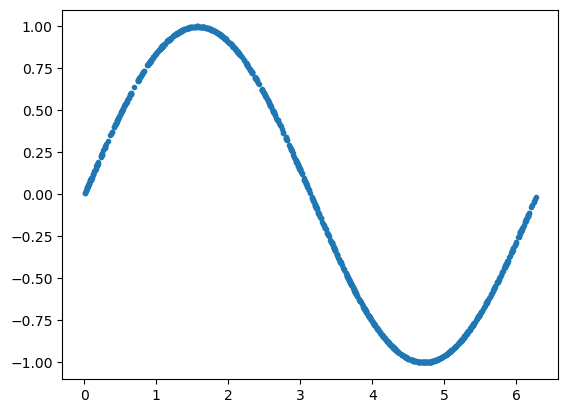

In [5]:
plt.plot(train_data[:,0], train_data[:, 1], ".")

Next, using the training set, we will create a data loader and specify a batch size. The batch size is the parameter that defines the number of samples to work through before updating model parameters.

In [6]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

**PART B:** Read over the following `Discriminator` class. The discriminator is a model with a two-dimensional input and a one-dimensional output. It will receive a sample from real data or from the generator and will provide the probability that the sample belongs to the real training data.

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [8]:
# Instantiate a discriminator object
discriminator = Discriminator()

**PART C:** Read over the `Generator` class. The generator is the model that takes samples from a latent space as its input and generates data resembling the data in the training set. 

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()

**PART D**: Define the learning rate, the number of epochs, and a loss function.

In [10]:
lr = 0.001
num_epochs = 300
loss_function = nn.BCELoss()

**PART D:** Next, exectute the line of code given.

In [11]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

**PART E:** Now implement a training loop to train the samples that are fed in. The weights will be updated to minimize the loss function.

In [12]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 2))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.15663041174411774
Epoch: 0 Loss G.: 2.1256043910980225
Epoch: 10 Loss D.: 0.6571139693260193
Epoch: 10 Loss G.: 0.8178414106369019
Epoch: 20 Loss D.: 0.6383627653121948
Epoch: 20 Loss G.: 0.9057258367538452
Epoch: 30 Loss D.: 0.5879160761833191
Epoch: 30 Loss G.: 0.7484802603721619
Epoch: 40 Loss D.: 0.5586228370666504
Epoch: 40 Loss G.: 1.01658034324646
Epoch: 50 Loss D.: 0.6439600586891174
Epoch: 50 Loss G.: 0.750975489616394
Epoch: 60 Loss D.: 0.8144655823707581
Epoch: 60 Loss G.: 0.5160590410232544
Epoch: 70 Loss D.: 0.7321587800979614
Epoch: 70 Loss G.: 0.7114300727844238
Epoch: 80 Loss D.: 0.7137088775634766
Epoch: 80 Loss G.: 0.6991386413574219
Epoch: 90 Loss D.: 0.6631389856338501
Epoch: 90 Loss G.: 0.7840858697891235
Epoch: 100 Loss D.: 0.6799262762069702
Epoch: 100 Loss G.: 0.7404754757881165
Epoch: 110 Loss D.: 0.7509774565696716
Epoch: 110 Loss G.: 0.7696004509925842
Epoch: 120 Loss D.: 0.7215709090232849
Epoch: 120 Loss G.: 0.7273547053337097
Epoch: 130

**PART F:** After your model is finished training, you will draw ramdom samples from the latent space and feed them into the generator.

In [13]:
latent_space_samples = torch.randn(100, 2)
generated_samples = generator(latent_space_samples)

**PART F** Plot the model that we developed.

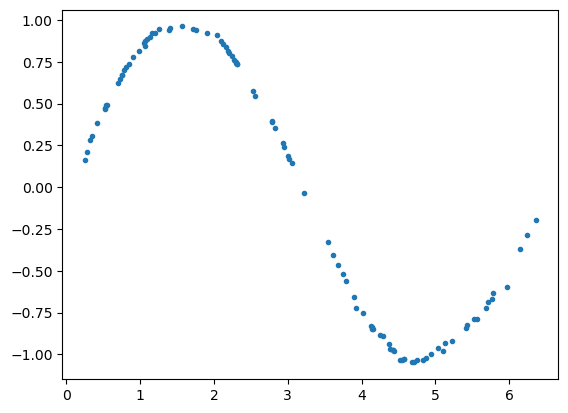

In [16]:
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:,0], generated_samples[:,1], ".")